In [153]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from sklearn.cluster import DBSCAN, KMeans
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, BayesianRidge
from sklearn.metrics import r2_score, silhouette_score, davies_bouldin_score

In [154]:
# Установка уровня журналирования для Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [155]:
start_time = time.time()

1 Исходные данные

In [156]:
'''Номера наборов данных для взаимных спротивлений влияющих и отключенной ЛЭП - dataset_z_powerlines_{data_z} и
наведенного напряжения на отключенной ЛЭП - dataset_voltage_{data_z}_{data_U}'''
data_z = 1
data_U = 4

# Фиксация генератора случайных чисел
random_seed = 1953
np.random.seed(random_seed)

# Наибольшие значения модулей токов прямой последовательности в начале и конце влияющих ЛЭП (для оптимизации целевой переменной - наведенного напряжения на отключенной ЛЭП)
I1_N = [1500, 1200, 1600, 1600, 1200]
I1_K = [1500, 1200, 1600, 1600, 1200]

# Наибольшие коэффициенты токов обратной и нулевой последовательности в начале и конце влияющих ЛЭП
k_N_2, k_K_2 = 0.100, 0.100
k_N_0, k_K_0 = 0.065, 0.065

# Отн. погрешности измерений значений токов влияющих ЛЭП (элементов матрицы A_h) и наведенного напряжения на отключенной ЛЭП (элементов столбца b_d)
k_A = 0.010
k_b = 0.050

# Доля используемых данных из полного набора данных (датасета)
delta_data = 1

# Относительный размер тестовой выборки
test_size = 0.2

2 Загрузка датасетов

In [157]:
# Пути для загрузки датасетов
output_path_dat = f'C:/Datasets/dataset_voltage_{data_z}_{data_U}.xlsx'
output_path_z = f'C:/Datasets/dataset_z_powerlines_{data_z}.xlsx'

In [158]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel(output_path_z).astype(complex)
z_complex_acc.T

,0,1,2,3,4,5
z(1),0.0400+0.0060j,0.0380+0.0055j,0.0360+0.0050j,0.0350+0.0048j,0.0330+0.0045j,0.0300+0.0044j
z(2),0.0200+0.0025j,0.0180+0.0022j,0.0160+0.0020j,0.0150+0.0019j,0.0140+0.0016j,0.0120+0.0014j
z(3),0.0180+0.0022j,0.0160+0.0020j,0.0150+0.0018j,0.0130+0.0016j,0.0120+0.0015j,0.0110+0.0014j
z(4),0.0160+0.0020j,0.0140+0.0018j,0.0130+0.0016j,0.0100+0.0015j,0.0090+0.0014j,0.0080+0.0012j
z(5),0.0150+0.0018j,0.0140+0.0016j,0.0130+0.0015j,0.0110+0.0012j,0.0100+0.0012j,0.0090+0.0010j


In [159]:
# Загрузка датасета (данные из комплексных чисел)
df_complex = pd.read_excel(output_path_dat).astype(complex)
df_complex.head()

,a1_1_h,b1_1_h,c1_1_h,a2_1_h,b2_1_h,c2_1_h,a1_2_h,b1_2_h,c1_2_h,a2_2_h,...,a2_4_h,b2_4_h,c2_4_h,a1_5_h,b1_5_h,c1_5_h,a2_5_h,b2_5_h,c2_5_h,b_d
0,198.285232+0.000000j,-99.755820-172.782148j,-99.496149+172.332386j,199.739539+0.000000j,-100.242244-173.624660j,-100.939031+174.831530j,124.778403+0.000000j,-62.585692-108.401598j,-62.603513+108.432466j,123.874502+0.000000j,...,297.506865+0.000000j,-150.651372-260.935830j,-151.268457+262.004653j,171.647648+0.000000j,-84.788575-146.858119j,-84.711275+146.724232j,170.858992+0.000000j,-85.651929-148.353493j,-85.365520+147.857419j,4.895810-1.876515j
1,198.620371+0.000000j,-99.313810-172.016565j,-100.008263+173.219393j,201.504585+0.000000j,-99.113064-171.668862j,-99.484823+172.312767j,124.867749+0.000000j,-63.118274-109.324058j,-62.945451+109.024719j,125.452009+0.000000j,...,297.964767+0.000000j,-149.255588-258.518262j,-150.606670+260.858404j,170.723889+0.000000j,-84.722490-146.743658j,-85.670736+148.386068j,171.337518+0.000000j,-84.221285-145.875545j,-85.598187+148.260408j,4.753753-1.829324j
2,201.737338+0.000000j,-99.917896-173.062872j,-100.156486+173.476123j,201.775007+0.000000j,-100.170320-173.500083j,-99.854198+172.952544j,124.441076+0.000000j,-62.764998-108.712166j,-62.195356+107.725517j,125.240085+0.000000j,...,301.517554+0.000000j,-150.187742-260.132799j,-149.952704+259.725702j,171.237052+0.000000j,-85.004062-147.231354j,-85.230829+147.624126j,169.863699+0.000000j,-84.970750-147.173656j,-85.428121+147.965846j,4.995858-1.928262j
3,198.131118+0.000000j,-100.998790-174.935036j,-100.411576+173.917951j,199.329457+0.000000j,-100.934754-174.824122j,-100.935091+174.824706j,124.603978+0.000000j,-62.418655-108.112281j,-62.748018+108.682756j,125.764437+0.000000j,...,298.373997+0.000000j,-149.148041-258.331984j,-149.502401+258.945754j,169.390504+0.000000j,-85.248393-147.654549j,-84.925739+147.095695j,169.715922+0.000000j,-84.607833-146.545065j,-84.845471+146.956667j,4.822412-1.861522j
4,198.553235+0.000000j,-99.281003-171.959742j,-100.137398+173.443061j,198.627307+0.000000j,-100.555570-174.167357j,-100.546246+174.151207j,125.436724+0.000000j,-62.730166-108.651834j,-62.884327+108.918849j,124.757701+0.000000j,...,297.850244+0.000000j,-149.363822-258.705729j,-151.268560+262.004831j,170.405383+0.000000j,-85.921038-148.819603j,-84.663550+146.641569j,169.319108+0.000000j,-84.422399-146.223885j,-84.490303+146.341498j,5.017751-1.939957j


3 Использование для обучения только части датасета

In [160]:
NNN = int(1. // delta_data)
df_complex = df_complex.iloc[::NNN]

4 Попарные графики рассеяния b_d от модулей токов

In [161]:
df_real = df_complex.applymap(lambda x: x.real)
df_imag = df_complex.applymap(lambda x: x.imag)
df_modul = df_complex.applymap(lambda x: abs(x))
# real_parts_predictors = df_complex.iloc[:, :-1].applymap(lambda x: x.real)
# target_module = abs(df_complex.iloc[:, -1])
# df_modul = pd.concat([real_parts_predictors, target_module], axis=1)

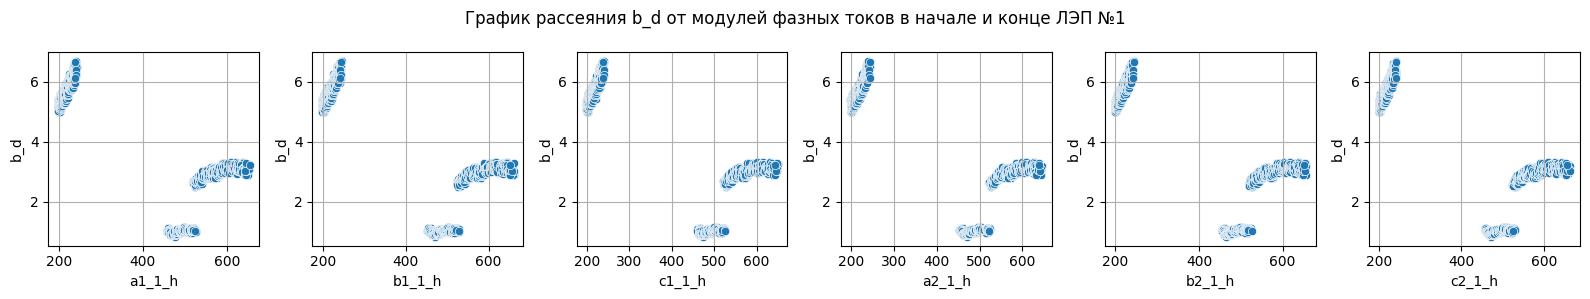

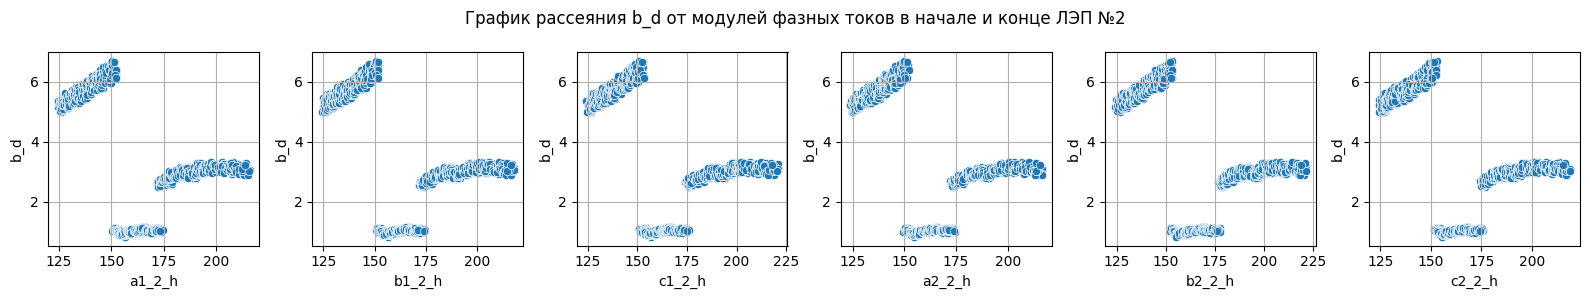

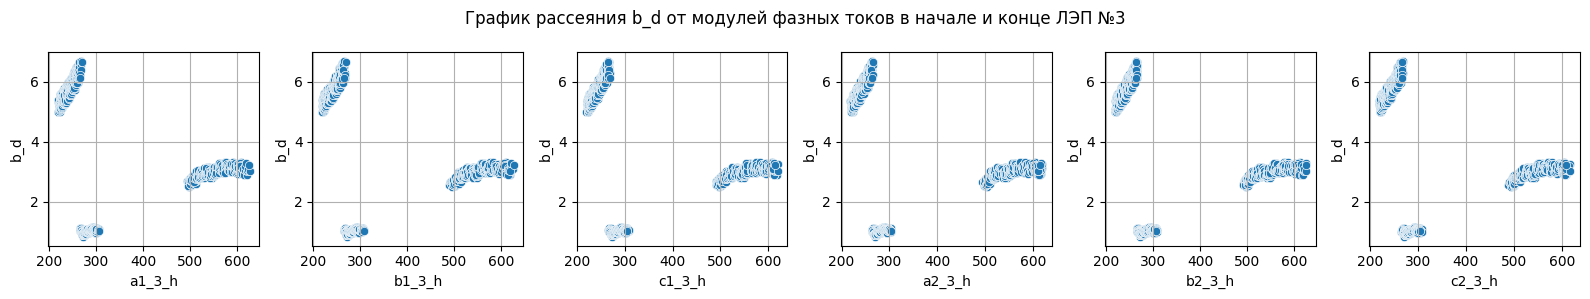

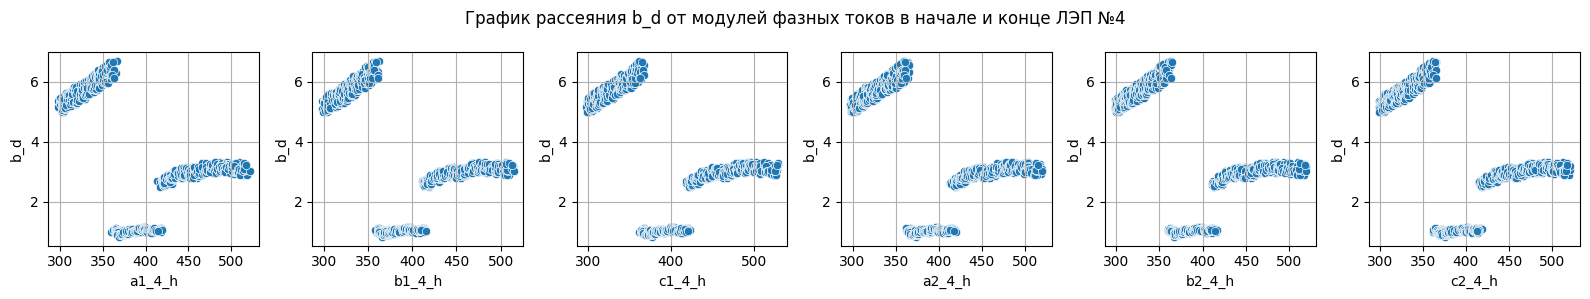

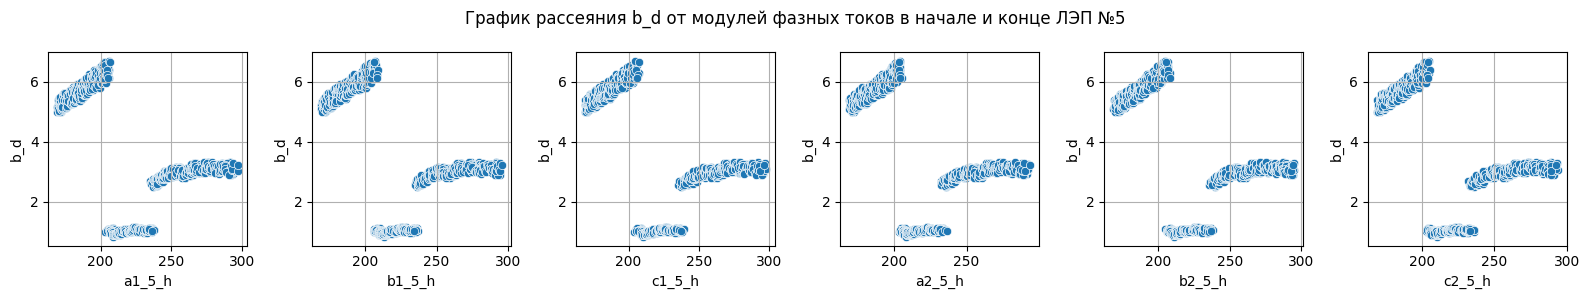

In [162]:
# Размер группы столбцов
group_size = 6

last_column = df_modul.columns[-1]

num_columns = len(df_modul.columns) - 1

# Разделение столбцов на группы и создание графиков
group_number = 1  # Начальный номер группы
for i in range(0, num_columns, group_size):
    group = df_modul.columns[i:i + group_size]
    num_plots = len(group)
    
    # Создание сетки для графиков
    fig, axes = plt.subplots(1, num_plots, figsize=(16, 3))
    
    # Построение графиков рассеяния
    for j, column in enumerate(group):
        sns.scatterplot(data=df_modul, x=column, y=last_column, ax=axes[j], marker='o')
        axes[j].set_xlabel(column)
        axes[j].set_ylabel(last_column)
        axes[j].grid(True)
    
    fig.suptitle(f'График рассеяния {last_column} от модулей фазных токов в начале и конце ЛЭП №{group_number}')
    group_number += 1
    plt.tight_layout()
    plt.show()

5 Кластеризация данных датасета для выделения участков регрессии с различными направлениями передачи энергии

In [163]:
df_features = df_modul.copy()
# df_features = df_real.copy()
# df_features = df_imag.copy()

5.1 Кластеризация данных алгоритмом KMeans

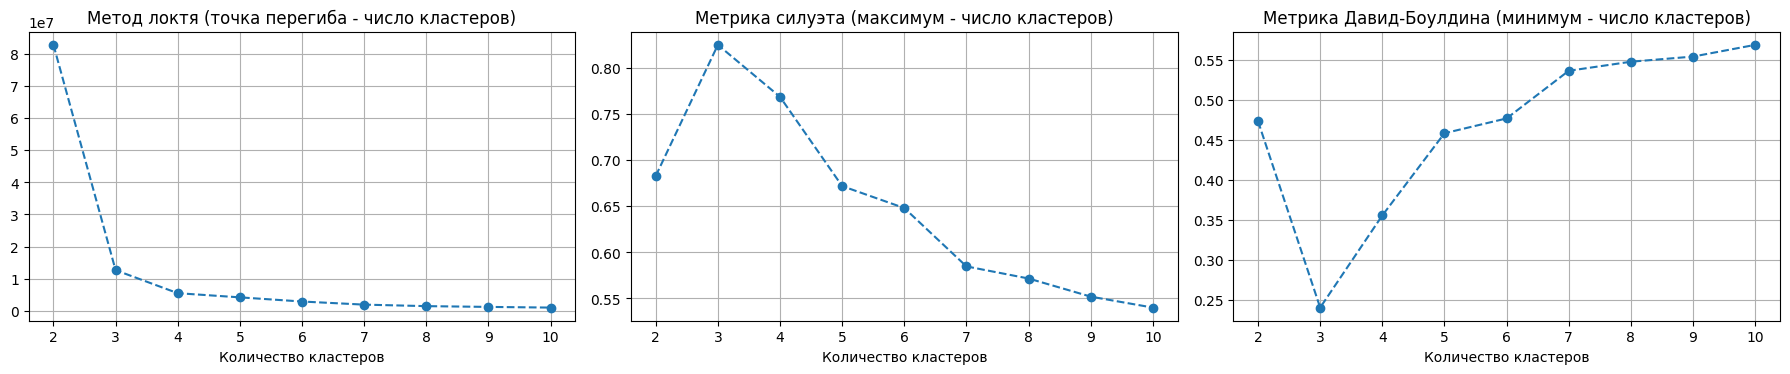

In [164]:
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []
cluster_models = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_features)
    cluster_labels = kmeans.labels_
    
    # Сохранение обученных моделей
    cluster_models[k] = kmeans
    
    # Метрика инерции (сумма квадратов расстояний от точек до их ближайшего центроида)
    inertia_values.append(kmeans.inertia_)
    
    # Метрика силуэта (вычисляется только для k > 1)
    if k > 1:
        silhouette_scores.append(silhouette_score(df_features, cluster_labels))
    
    # Метрика Давида-Боулдина
    davies_bouldin_scores.append(davies_bouldin_score(df_features, cluster_labels))

metrics = [inertia_values, silhouette_scores, davies_bouldin_scores]
titles = ['Метод локтя (точка перегиба - число кластеров)', 'Метрика силуэта (максимум - число кластеров)', 'Метрика Давид-Боулдина (минимум - число кластеров)']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    axes[i].plot(range(2, 11), metric, marker='o', linestyle='--')
    axes[i].set_xlabel('Количество кластеров')
    axes[i].set_title(title)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [165]:
df_cl = df_complex.copy()

n_clusters = 3

# Метки кластеров для каждой строки в датафрейме
cluster_labels = cluster_models[n_clusters].labels_
# print(cluster_labels + 1)

# Добавление столбца с метками кластеров к датафрейму
df_features['Cluster'] = cluster_labels + 1
df_cl['Cluster'] = cluster_labels + 1

# Создание датафреймов для каждого кластера
df_cluster = {}
for cluster_id in range(1, n_clusters + 1):
    df_cluster[cluster_id] = df_cl[df_cl['Cluster'] == cluster_id].drop('Cluster', axis=1)

5.2 Кластеризация данных алгоритмом DBSCAN

In [166]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

# Параметры для DBSCAN
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_values = [5, 10, 15, 20, 25]
dbscan_models = {}

# Метрики
silhouette_scores = []
davies_bouldin_scores = []

# Перебор параметров DBSCAN
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_features)
        
        # Сохранение обученных моделей
        dbscan_models[(eps, min_samples)] = dbscan
        
        # Метрика силуэта (вычисляется только для k > 1)
        if len(set(dbscan_labels)) > 1:
            silhouette_scores.append(silhouette_score(scaled_features, dbscan_labels))
        
        # Метрика Давида-Боулдина
        davies_bouldin_scores.append(davies_bouldin_score(scaled_features, dbscan_labels))


# Выбор лучшей конфигурации DBSCAN
best_eps, best_min_samples = eps_values[min(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i])], min_samples_values[min(range(len(silhouette_scores)), key=lambda i: silhouette_scores[i])]
print(f'Лучшая конфигурация DBSCAN: eps={best_eps}, min_samples={best_min_samples}')

# Использование лучшей модели для DBSCAN
best_dbscan = dbscan_models[(best_eps, best_min_samples)]
dbscan_labels = best_dbscan.labels_

# Добавление столбца с метками кластеров к датафрейму
df_features['Cluster'] = dbscan_labels + 1

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f'Число кластеров (DBSCAN): {n_clusters}')

df_cl = df_complex.copy()
df_cl['Cluster'] = dbscan_labels + 1

# Создание датафреймов для каждого кластера
df_cluster = {}
for cluster_id in range(1, n_clusters + 1):
    df_cluster[cluster_id] = df_cl[df_cl['Cluster'] == cluster_id].drop('Cluster', axis=1)

Лучшая конфигурация DBSCAN: eps=0.5, min_samples=5
Число кластеров (DBSCAN): 3


6 Визуализация кластеризации данных датасета

Кластер 1: размер 350
Кластер 2: размер 250
Кластер 3: размер 400


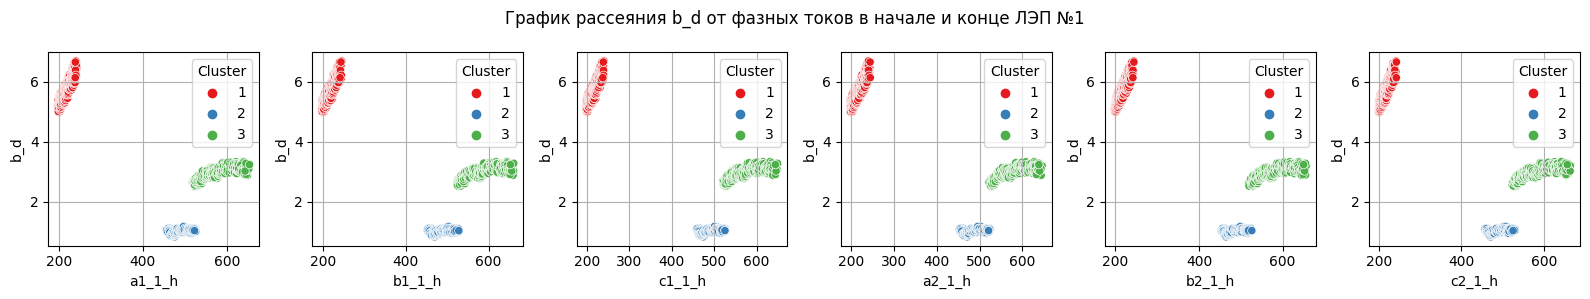

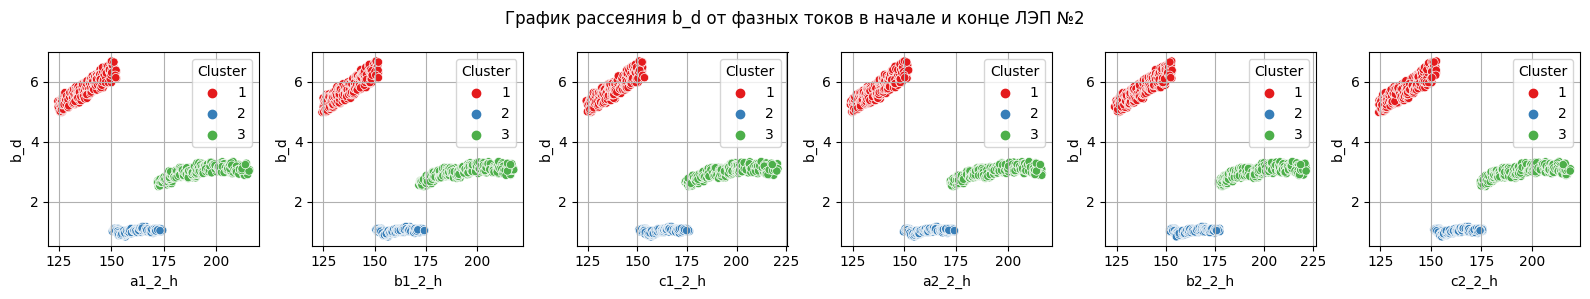

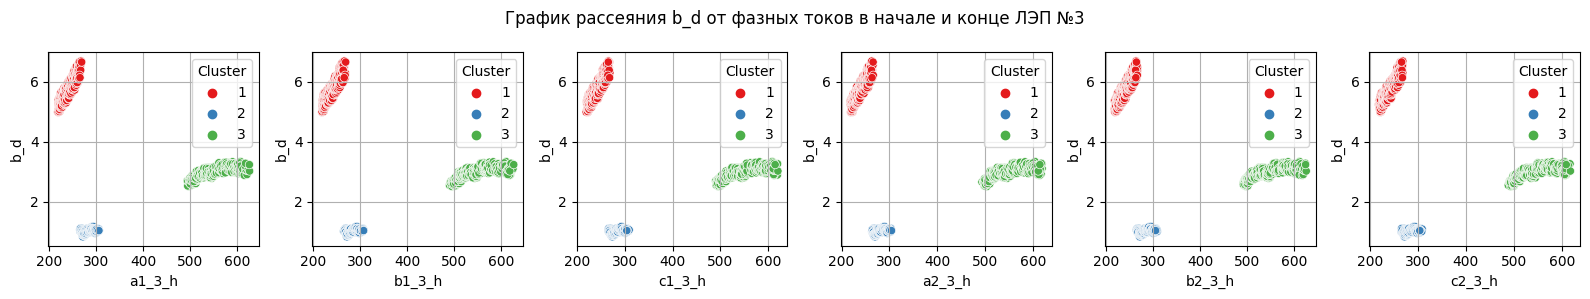

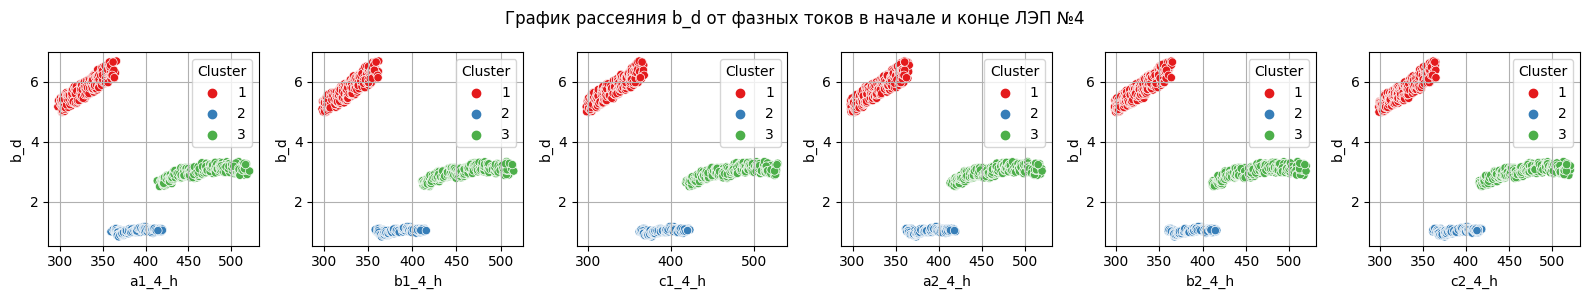

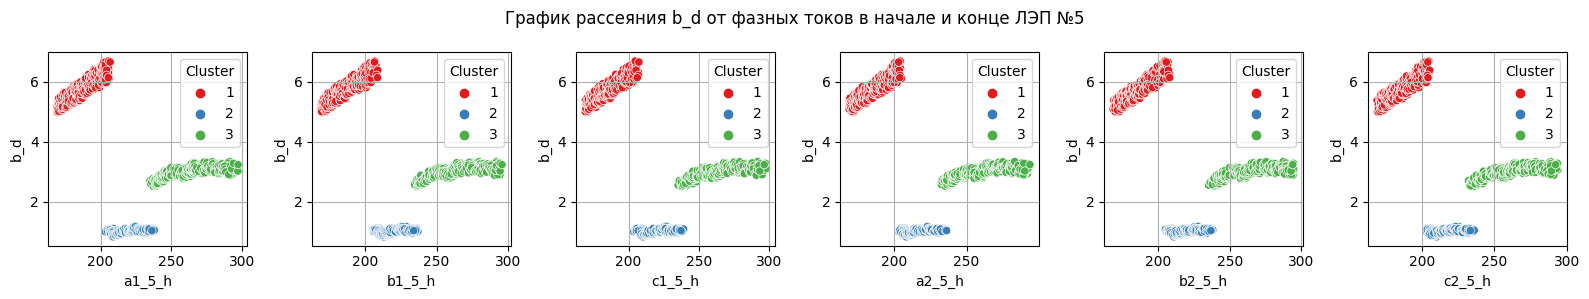

In [167]:
for i in range(1, n_clusters + 1):
    print(f'Кластер {i}: размер {df_cluster[i].shape[0]}')

palette = sns.color_palette("Set1", n_clusters)

# Количество столбцов в датафрейме (кроме последнего и предпоследнего)
num_columns = len(df_features.columns) - 2

# Разделение столбцов на группы и создание графиков
group_number = 1  # Начальный номер группы
for i in range(0, num_columns, group_size):
    group = df_features.columns[i:i + group_size]
    num_plots = len(group)
    
    # Создание сетки для графиков
    fig, axes = plt.subplots(1, num_plots, figsize=(16, 3))
    
    # Построение графиков рассеяния с цветами из цветовой палитры
    for j, column in enumerate(group):
        sns.scatterplot(data=df_features, x=column, y=last_column, hue='Cluster', palette=palette, ax=axes[j], marker='o', legend=True)
        axes[j].set_xlabel(column)
        axes[j].set_ylabel(last_column)
        axes[j].grid(True)  # Добавление линий сетки
    
    fig.suptitle(f'График рассеяния {last_column} от фазных токов в начале и конце ЛЭП №{group_number}')
    group_number += 1
    plt.tight_layout()
    plt.show()

In [168]:
# Создание словарей для хранения обученных моделей и их метрик
unbalance_df = {}
models = {}
model_coeff = {}
metrics = {}

for i in range(n_clusters + 1):
    unbalance_df[i] = {}
    models[i] = {}
    model_coeff[i] = {}
    metrics[i] = {}

In [169]:
# Комплексные операторы поворота фазных токов
b_rot = complex(-0.5, -1 * np.sqrt(3) / 2)
c_rot = complex(-0.5, np.sqrt(3) / 2)

7 Функции

7.1 Функция преобразования фазных токов в симметричные составляющие

In [170]:
def apply_operations(row):
    df_row = []
    for i in range(0, len(row), 3):
        if i + 2 < len(row):  # Проверяем, что есть достаточно элементов для выполнения операции
            df_row.extend([(row[i] + row[i + 1] * c_rot + row[i + 2] * b_rot) / 3,
                           (row[i] + row[i + 1] * b_rot + row[i + 2] * c_rot) / 3,
                            row[i] + row[i + 1] + row[i + 2]])
    
    return df_row

7.2 Функция формирования вещественных матриц A_train и A_test признаков и вещественных векторов b_train и b_test целевой переменной

In [171]:
def transformation_into_real_arrays(A_complex, b_complex):
    A_real = A_complex.real
    A_imag = A_complex.imag
    A_1 = pd.concat([pd.DataFrame(A_real), pd.DataFrame(A_imag)], axis=0)
    A_2 = pd.concat([-1 * pd.DataFrame(A_imag), pd.DataFrame(A_real)], axis=0)
    
    index_data = np.arange(A_1.shape[0])
    A_1.index = index_data
    A_2.index = index_data
    
    A_transformed = pd.merge(A_1, A_2, left_index=True, right_index=True)
    A_transformed.columns = [f'A_{i+1}' for i in range(A_transformed.shape[1])]
    
    b_real = b_complex.real
    b_imag = b_complex.imag
    b_transformed = pd.concat([pd.DataFrame(b_real), pd.DataFrame(b_imag)], axis=0)
    b_transformed.index = index_data
    b_transformed.columns = ['b']
    
    return A_transformed, b_transformed

7.3 Функция вычисления обобщенной невязки delta_residual

In [172]:
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2
    
    return delta_residual

7.4 Функция преобразования взаимных сопротивлений в симметричные составляющие

In [173]:
def apply_operations_z(z, A_0):
    result_vector = []
    i = 0
    while i < len(A_0):
        result_vector.append(z[i] + z[i + 1] * b_rot + z[i + 2] * c_rot)
        result_vector.append(z[i] + z[i + 1] * c_rot + z[i + 2] * b_rot)
        result_vector.append((z[i] + z[i + 1] + z[i + 2]) / 3)
        i += 3
    
    return result_vector

7.5 Функция обучения моделей с поиском гиперпараметров на сетке

In [174]:
def train_model_GridSearchCV(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, model_name):
    if model_name == 'Ridge':
        rid = Ridge(fit_intercept=False)
        rid_parameters = {'alpha': np.logspace(-7, 3, num=201), 
                        'random_state': [1, 7, 42, 100, random_seed],
    }
        model = GridSearchCV(estimator=rid,
                        param_grid=rid_parameters,
                        scoring='r2',
                        n_jobs=-1,
                        cv=5)
    elif model_name == 'SGDRegressor':
        sgd = SGDRegressor(fit_intercept=False)
        sgd_parameters = {'alpha': np.logspace(-7, 3, num=201),
                        'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
                        'random_state': [1, 7, 42, 100, random_seed]
    }
        model = GridSearchCV(estimator=sgd,
                        param_grid=sgd_parameters,
                        scoring='r2',
                        n_jobs=-1,
                        cv=5)
    elif model_name == 'Lasso':
        lass = Lasso(fit_intercept=False)
        lass_parameters = {'alpha': np.logspace(-7, 3, num=201), 
                          'random_state': [1, 7, 42, 100, random_seed]
    }
        model = GridSearchCV(estimator=lass,
                        param_grid=lass_parameters,
                        scoring='r2', # 'neg_mean_absolute_error'
                        n_jobs=-1,
                        cv=5)
    elif model_name == 'BayesianRidge':
        bay = BayesianRidge(fit_intercept=False)
        bay_parameters = {
            'alpha_1':  np.logspace(1e-6, 1, num=6),
            'alpha_2':  np.logspace(1e-6, 1, num=6),
            'lambda_1': np.logspace(1e-6, 1, num=6),
            'lambda_2': np.logspace(1e-6, 1, num=6)
    }
        model = GridSearchCV(estimator=bay,
                        param_grid=bay_parameters,
                        scoring='r2', # 'neg_mean_absolute_error'
                        n_jobs=-1,
                        cv=5)

    model.fit(X_train_std, y_train)
    best_model = model.best_estimator_

    coefficients = best_model.coef_
    z_real = coefficients.flatten()[:len(X_train_std[0]) // 2]
    z_imag = coefficients.flatten()[len(X_train_std[0]) // 2:]
    z_modul = np.sqrt(z_real**2 + z_imag**2)
    U_max = np.dot(np.array(I_max_std_modul), np.array(z_modul))

    y_pred = best_model.predict(X_test_std)
    y_pred_train = best_model.predict(X_train_std)

    r2_train = r2_score(y_train, y_pred_train).round(3)
    r2_test = r2_score(y_test, y_pred).round(3)

    return best_model, z_modul, U_max, r2_train, r2_test

7.6 Функция обучения моделей с поиском гиперпараметров алгоритмами Optuna

In [175]:
def train_model_Optuna(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, model_name):
    if model_name == 'Ridge':
        opt_params = {
            'alpha': (1e-7, 1e3),
            'random_state': (1, 100)
        }
        model_class = Ridge
    elif model_name == 'SGDRegressor':
        opt_params = {
            'alpha': (1e-7, 1e3),
            'l1_ratio': (0.05, 1),
            'random_state': (1, 100)
        }
        model_class = SGDRegressor
    elif model_name == 'Lasso':
        opt_params = {
            'alpha': (1e-10, 1e-1),
            'random_state': (1, 100)
        }
        model_class = Lasso
    elif model_name == 'BayesianRidge':
        opt_params = {
            'alpha_1':  (1e-6, 1),
            'alpha_2':  (1e-6, 1),
            'lambda_1': (1e-6, 1),
            'lambda_2': (1e-6, 1)
        }
        model_class = BayesianRidge

    def objective(trial):
        params = {}
        for param_name, param_range in opt_params.items():
            if param_name == 'random_state':
                params[param_name] = trial.suggest_int(param_name, *param_range)
            else:
                params[param_name] = trial.suggest_uniform(param_name, *param_range)

        model = model_class(**params, fit_intercept=False)
        model.fit(X_train_std, y_train)

        y_pred = model.predict(X_test_std)
        r2 = r2_score(y_test, y_pred)

        return r2


    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))
    study.optimize(objective, n_trials=200)

    optimal_params = study.best_params
    final_model = model_class(**optimal_params, fit_intercept=False)
    final_model.fit(X_train_std, y_train)

    final_coefficients = final_model.coef_
    z_real = final_coefficients.flatten()[:len(X_train_std[0]) // 2]
    z_imag = final_coefficients.flatten()[len(X_train_std[0]) // 2:]
    z_modul = np.sqrt(z_real**2 + z_imag**2)
    U_max = np.dot(np.array(I_max_std_modul), np.array(z_modul))

    y_pred = final_model.predict(X_test_std)
    y_pred_train = final_model.predict(X_train_std)

    r2_train = r2_score(y_train, y_pred_train).round(3)
    r2_test = r2_score(y_test, y_pred).round(3)

    return final_model, z_modul, U_max, r2_train, r2_test

7.7 Функция вычисления наибольших значений токов небаланса в ЛЭП

In [176]:
def unbalance_current(i_cluster=0):
    if i_cluster == 0:
        df = df_complex
    else:
        df = df_cluster[i_cluster]

    # Вычисление долей наибольшего и ср.квадр. модулей тока небаланса от наибольшего модуля тока фазы А для каждой ЛЭП
    df_sum = pd.DataFrame()

    for i in range(0, len(df.iloc[0])-1, 3):
        feature_group = df.iloc[:, i:i+3]
        sum_features = feature_group.sum(axis=1)
        df_sum[f'Jo_{i//3 + 1}'] = sum_features

    df_sum['b_d'] = df['b_d']
    IA_values = np.max(np.abs(df.iloc[:, ::3]), axis=0)
    max_values = np.max(np.abs(df_sum), axis=0)
    rms_values = np.sqrt(np.mean(np.abs(df_sum) ** 2, axis=0))

    IA_values = IA_values.reset_index(drop=True)
    max_values.index = IA_values.index
    rms_values.index = IA_values.index

    delta_max = max_values / IA_values
    delta_rms = rms_values / IA_values
    unbalance_df[i_cluster] = pd.DataFrame({
        'IA_max, A': IA_values.round(1),
        '3I0_max/IA_max': delta_max,
        '3I0_rms/IA_max': delta_rms
    })
    unbalance_df[i_cluster] = unbalance_df[i_cluster].rename(index={unbalance_df[i_cluster].index[-1]: 'U_induced_max'})

    return unbalance_df[i_cluster]

7.8 Функция оптимизации целевой переменной

In [177]:
def target_optimization(i_cluster=0):
    if i_cluster == 0:
        df = df_complex
    else:
        df = df_cluster[i_cluster]
   
  
    # Преобразование датасета df в симметричные составляющие
    df_copy = df.copy()
    df_symcomp = df_copy.apply(apply_operations, axis=1, result_type='expand')
    df_symcomp['b_d'] = df_copy['b_d']

    # Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_symcomp
    A_complex = df_symcomp.iloc[:, :-1].values
    b_complex = df_symcomp.iloc[:, -1].values

    # Разбиение на обучающую и тестовые выборки
    A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                        b_complex,
                                                                                        test_size=test_size,
                                                                                        random_state=random_seed)

    # Формирование вещественных матриц A_train и A_test признаков и вещественных векторов b_train и b_test целевой переменной
    A_train, b_train = transformation_into_real_arrays(A_train_complex, b_train_complex)
    A_test, b_test = transformation_into_real_arrays(A_test_complex, b_test_complex)

    # Формирование матрицы I_max (для последующего масштабирования обученным скэлером)
    I_max = [val for a_n, a_k in zip(I1_N, I1_K) for val in [a_n, a_n * k_N_2, 3 * a_n * k_N_0, a_k, a_k * k_K_2, 3 * a_k * k_K_0]]
    I_max_real = np.array(I_max).real
    I_max_imag = np.array(I_max).imag
    I_max_1 = pd.concat([pd.DataFrame(I_max_real), -1 * pd.DataFrame(I_max_imag)], axis=0)
    I_max_2 = pd.concat([pd.DataFrame(I_max_imag), pd.DataFrame(I_max_real)], axis=0)
    index_max = np.arange(I_max_1.shape[0])
    I_max_1.index = index_max
    I_max_2.index = index_max 
    I_max = pd.merge(I_max_1, I_max_2, left_index=True, right_index=True)
    I_max = I_max.T

    # МАСШТАБИРОВАНИЕ ПРИЗНАКОВ
    sc = MaxAbsScaler()    # MaxAbsScaler()    MinMaxScaler()    StandardScaler()

    X_train_std = sc.fit_transform(A_train) # Переход к привычным обозначениям X для признаков
    X_test_std = sc.transform(A_test) # Переход к привычным обозначениям X для признаков

    y_train = b_train # Переход к привычным обозначениям y для целевой переменной
    y_test = b_test # Переход к привычным обозначениям y для целевой переменной

    # Масштабирование матрицы I_max
    I_max_std = sc.transform(I_max)

    # Вычисление числа признаков
    num_predictors = len(A_complex[0])

    # Вычисление модуля масштабированного вектора I_max
    I_max_std_modul = I_max_std[0, :num_predictors]

    # ОБУЧЕНИЕ МОДЕЛЕЙ ЛИНЕЙНЫХ РЕГРЕССОРОВ
    # 1. LinearRegression
    lr = LinearRegression(fit_intercept=False)
    model_lr = lr.fit(X_train_std, y_train)
    models[i_cluster]['model_lr'] = model_lr

    z_lr_real = model_lr.coef_.flatten()[:num_predictors]
    z_lr_imag = model_lr.coef_.flatten()[num_predictors:]
    z_lr_modul = np.sqrt(z_lr_real**2 + z_lr_imag**2)
    U_lr_max = np.dot(np.array(I_max_std_modul), np.array(z_lr_modul))
    model_coeff[i_cluster]['LinearRegr'] = z_lr_modul

    y_lr_pred = model_lr.predict(X_test_std)
    y_lr_pred_train = model_lr.predict(X_train_std)

    r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
    r2_lr_test = r2_score(y_test, y_lr_pred).round(3)
    metrics[i_cluster]['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(U_lr_max, 1))

    
    # 2. Ridge
    # GridSearchCV
    best_rid_model, z_rid_modul, U_rid_max, r2_rid_train, r2_rid_test = train_model_GridSearchCV(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'Ridge')
    models[i_cluster]['Ridge_GS'] = best_rid_model
    model_coeff[i_cluster]['Ridge_GS'] = z_rid_modul
    metrics[i_cluster]['Ridge_GS'] = (str(r2_rid_train), str(r2_rid_test), np.round(U_rid_max, 1))
    # OPTUNA
    best_rid_opt_model, z_rid_opt_modul, U_rid_opt_max, r2_rid_opt_train, r2_rid_opt_test = train_model_Optuna(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'Ridge')
    models[i_cluster]['Ridge_Opt'] = best_rid_opt_model
    model_coeff[i_cluster]['Ridge_Opt'] = z_rid_opt_modul
    metrics[i_cluster]['Ridge_Opt'] = (str(r2_rid_opt_train), str(r2_rid_opt_test), np.round(U_rid_opt_max, 1))


    # 3. SGDRegressor
    # GridSearchCV
    best_sgd_model, z_sgd_modul, U_sgd_max, r2_sgd_train, r2_sgd_test = train_model_GridSearchCV(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'SGDRegressor')
    models[i_cluster]['SGDRegr_GS'] = best_sgd_model
    model_coeff[i_cluster]['SGDRegr_GS'] = z_sgd_modul
    metrics[i_cluster]['SGDRegr_GS'] = (str(r2_sgd_train), str(r2_sgd_test), np.round(U_sgd_max, 1))
    # OPTUNA
    best_sgd_opt_model, z_sgd_opt_modul, U_sgd_opt_max, r2_sgd_opt_train, r2_sgd_opt_test = train_model_Optuna(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'SGDRegressor')
    models[i_cluster]['SGDRegr_Opt'] = best_sgd_opt_model
    model_coeff[i_cluster]['SGDRegr_Opt'] = z_sgd_opt_modul
    metrics[i_cluster]['SGDRegr_Opt'] = (str(r2_sgd_opt_train), str(r2_sgd_opt_test), np.round(U_sgd_opt_max, 1))


    # 4. Lasso
    # GridSearchCV
    best_lass_model, z_lass_modul, U_lass_max, r2_lass_train, r2_lass_test = train_model_GridSearchCV(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'Lasso')
    models[i_cluster]['Lasso_GS'] = best_lass_model
    model_coeff[i_cluster]['Lasso_GS'] = z_lass_modul
    metrics[i_cluster]['Lasso_GS'] = (str(r2_lass_train), str(r2_lass_test), np.round(U_lass_max, 1))
    # OPTUNA
    best_lass_opt_model, z_lass_opt_modul, U_lass_opt_max, r2_lass_opt_train, r2_lass_opt_test = train_model_Optuna(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'Lasso')
    models[i_cluster]['Lasso_Opt'] = best_lass_opt_model
    model_coeff[i_cluster]['Lasso_Opt'] = z_lass_opt_modul
    metrics[i_cluster]['Lasso_Opt'] = (str(r2_lass_opt_train), str(r2_lass_opt_test), np.round(U_lass_opt_max, 1))


    # 5. BayesianRidge
    # GridSearchCV
    best_bay_model, z_bay_modul, U_bay_max, r2_bay_train, r2_bay_test = train_model_GridSearchCV(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'BayesianRidge')
    models[i_cluster]['BayesRidge_GS'] = best_bay_model
    model_coeff[i_cluster]['BayesRidge_GS'] = z_bay_modul
    metrics[i_cluster]['BayesRidge_GS'] = (str(r2_bay_train), str(r2_bay_test), np.round(U_bay_max, 1))
    # OPTUNA
    best_bay_opt_model, z_bay_opt_modul, U_bay_opt_max, r2_bay_opt_train, r2_bay_opt_test = train_model_Optuna(X_train_std, y_train, X_test_std, y_test, I_max_std_modul, 'BayesianRidge')
    models[i_cluster]['BayesRidge_Opt'] = best_bay_opt_model
    model_coeff[i_cluster]['BayesRidge_Opt'] = z_bay_opt_modul
    metrics[i_cluster]['BayesRidge_Opt'] = (str(r2_bay_opt_train), str(r2_bay_opt_test), np.round(U_bay_opt_max, 1))


    # 6. Regularized
    ''' Удаление из матрицы токов столбцов со значениями для токов обратной последовательности,
    таким образом искусственно задается, что целевая переменная - наведенное напряжение зависит только 
    от токов прямой и нулевой последовательности (что соответствует физике наведенного напряжения)'''

    X_copy = X_train_std.copy()
    X_h = np.delete(X_copy, np.s_[1::3], axis=1)
    y_d = y_train

    # Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
    h = k_A * np.linalg.norm(X_h)
    d = k_b * np.linalg.norm(y_d)

    # Определение коэффициента регуляризации alpha методом обобщенной невязки
    calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
    alpha = newton(calculate_delta_residual_partial, x0=1e-15, tol=1e-7, maxiter=20000)
    # alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
    # alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-7)
    if alpha < 0:
        alpha = 0

    # Регуляризованное решение для токов прямой и обратной последовательности
    z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

    # Добавление нулевых значений для сопротивлений обратной последовательности
    new_rows = []

    for index, row in z_hd.iterrows():
        new_rows.append(row[0])
        if index % 2 == 0:
            new_rows.append(0.)

    z_hd = pd.DataFrame({'z': new_rows}).reset_index(drop=True)

    # Выполнение обратного масштабирования коэффициентов регрессии - взаимных сопротивлений
    z_array = z_hd.to_numpy()
    z_inv = sc.transform(z_array.reshape(1, -1))
    z_inv_df = pd.DataFrame(z_inv.reshape(-1, len(z_hd.columns)), columns=z_hd.columns)

    ''' Задание значений сопротивлений обратной последовательности значениями сопротивлений прямой последовательности,
    что соответствует физике наведенного напряжения'''

    z_inv_df.loc[1::3] = z_inv_df.shift(1).loc[1::3]

    # Выполнение масштабирования коэффициентов регрессии - взаимных сопротивлений
    z_array = z_inv_df.to_numpy()
    z_sc = sc.inverse_transform(z_array.reshape(1, -1))
    z_hd = pd.DataFrame(z_sc.reshape(-1, len(z_hd.columns)), columns=z_hd.columns)

    # Вычисление метрик
    y_reg_hd_pred = X_test_std @ z_hd
    y_reg_hd_pred_train = X_train_std @ z_hd

    r2_reg_hd_train = r2_score(y_train, y_reg_hd_pred_train).round(3)
    r2_reg_hd_test = r2_score(y_test, y_reg_hd_pred).round(3)

    z_hd_xy = z_hd.values.flatten()
    z_hd_real = z_hd_xy[:num_predictors]
    z_hd_imag = z_hd_xy[num_predictors:]
    z_hd_modul = np.sqrt(z_hd_real**2 + z_hd_imag**2)
    
    # Вычисление максимально возможного значения целевой переменной
    U_max_modul = np.dot(np.array(I_max_std_modul), np.array(z_hd_modul))
    model_coeff[i_cluster]['Regularized'] = z_hd_modul
    metrics[i_cluster]['Regularized'] = (str(r2_reg_hd_train), str(r2_reg_hd_test), np.round(U_max_modul, 1))

    # 7. Accurate
    # Вычисление условно точного максимально возможного значения целевой переменной (для контроля обучения моделей)
    z_acc = z_complex_acc.T.values.flatten()
    z_symm_acc = apply_operations_z(z_acc, A_complex[0])
    I_max_modul = I_max.iloc[0, :num_predictors]
    z_acc_modul = np.abs(z_symm_acc)
       
    U_max_acc_modul = np.dot(np.array(I_max_modul), np.array(z_acc_modul))
    metrics[i_cluster]['Accurate'] = ('', '', np.round(U_max_acc_modul, 1))

    return metrics[i_cluster]

8 Оптимизация целевой переменной

In [178]:
df_metrics = {}

for i in range(n_clusters + 1):
    target_optimization(i)
    df_metrics[i] = pd.DataFrame(metrics[i])
    df_metrics[i].index = ['R2 train', 'R2 test', 'u_max']
    df_metrics[i] = df_metrics[i].astype(object)

In [179]:
print(f'data_z = {data_z}     data_U = {data_U}')
print(f'Число строк датасета: {df_complex.shape[0]}')
print(f'k_A = {k_A:.3f}    k_b = {k_b:.3f}')
print()
print(f'k_N_2 = {k_N_2:.3f}  k_K_2 = {k_K_2:.3f}')
print(f'k_N_0 = {k_N_0:.3f}  k_K_0 = {k_K_0:.3f}')
print(f'random_seed = {random_seed}')
print()
print(f'Число выявленных кластеров в данных: {n_clusters}')

data_z = 1     data_U = 4
Число строк датасета: 1000
k_A = 0.010    k_b = 0.050

k_N_2 = 0.100  k_K_2 = 0.100
k_N_0 = 0.065  k_K_0 = 0.065
random_seed = 1953

Число выявленных кластеров в данных: 3


9 Таблицы относительных значений токов небаланса в каждом кластере

9.1 Кластер 1

In [180]:
unbalance_current(1).T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",242.700,244.900,152.400,152.100,269.500,266.400,366.000,365.800,206.800,205.300,6.700
3I0_max/IA_max,0.026,0.024,0.022,0.032,0.019,0.024,0.029,0.023,0.022,0.027,1.000
3I0_rms/IA_max,0.013,0.011,0.010,0.012,0.010,0.011,0.013,0.011,0.010,0.011,0.867


9.2 Кластер 2

In [181]:
unbalance_current(2).T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",525.200,523.800,174.400,174.300,306.500,304.500,419.700,419.500,238.000,236.300,1.200
3I0_max/IA_max,0.021,0.024,0.024,0.034,0.022,0.033,0.029,0.024,0.021,0.030,1.000
3I0_rms/IA_max,0.010,0.012,0.012,0.017,0.010,0.017,0.015,0.012,0.011,0.014,0.876


9.3 Кластер 3

In [182]:
unbalance_current(3).T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",653.200,646.000,215.900,216.600,627.100,619.200,521.700,520.000,297.400,293.700,3.300
3I0_max/IA_max,0.032,0.039,0.036,0.036,0.024,0.026,0.039,0.028,0.025,0.022,1.000
3I0_rms/IA_max,0.014,0.016,0.021,0.019,0.010,0.013,0.022,0.014,0.012,0.011,0.899


9.4 Полный набор данных

In [183]:
unbalance_current(0).T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",653.200,646.000,215.900,216.600,627.100,619.200,521.700,520.000,297.400,293.700,6.700
3I0_max/IA_max,0.032,0.039,0.036,0.036,0.024,0.026,0.039,0.028,0.025,0.024,1.000
3I0_rms/IA_max,0.010,0.012,0.015,0.015,0.007,0.009,0.016,0.011,0.010,0.010,0.591


10 Сводные таблицы метрик и прогнозов моделей

10.1 Кластер 1

In [184]:
df_metrics[1]

,LinearRegr,Ridge_GS,Ridge_Opt,SGDRegr_GS,SGDRegr_Opt,Lasso_GS,Lasso_Opt,BayesRidge_GS,BayesRidge_Opt,Regularized,Accurate
R2 train,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.995,
R2 test,0.999,0.999,0.999,0.998,0.999,0.999,0.999,0.999,0.999,0.994,
u_max,180.8,71.7,70.1,108.0,113.4,52.6,50.4,70.2,70.1,85.7,91.6


10.2 Кластер 2

In [185]:
df_metrics[2]

,LinearRegr,Ridge_GS,Ridge_Opt,SGDRegr_GS,SGDRegr_Opt,Lasso_GS,Lasso_Opt,BayesRidge_GS,BayesRidge_Opt,Regularized,Accurate
R2 train,0.991,0.99,0.99,0.986,0.986,0.99,0.99,0.99,0.991,0.989,
R2 test,0.991,0.989,0.99,0.983,0.983,0.989,0.99,0.99,0.99,0.988,
u_max,126.7,21.8,25.1,27.2,27.4,13.3,23.0,23.8,25.8,18.0,91.6


10.3 Кластер 3

In [186]:
df_metrics[3]

,LinearRegr,Ridge_GS,Ridge_Opt,SGDRegr_GS,SGDRegr_Opt,Lasso_GS,Lasso_Opt,BayesRidge_GS,BayesRidge_Opt,Regularized,Accurate
R2 train,0.997,0.997,0.997,0.995,0.995,0.997,0.997,0.997,0.997,0.995,
R2 test,0.997,0.997,0.997,0.995,0.995,0.997,0.997,0.997,0.997,0.995,
u_max,179.5,178.8,49.7,58.6,58.5,39.8,35.8,56.5,49.6,30.6,91.6


10.4 Полный набор данных

In [187]:
df_metrics[0]

,LinearRegr,Ridge_GS,Ridge_Opt,SGDRegr_GS,SGDRegr_Opt,Lasso_GS,Lasso_Opt,BayesRidge_GS,BayesRidge_Opt,Regularized,Accurate
R2 train,0.998,0.998,0.998,0.997,0.994,0.998,0.998,0.998,0.998,0.992,
R2 test,0.998,0.998,0.998,0.997,0.994,0.998,0.998,0.998,0.998,0.991,
u_max,125.7,112.1,66.3,105.8,112.2,68.9,70.5,73.4,69.6,67.3,91.6


11 Масштабированные коэффициенты регрессии различных моделей

In [188]:
for key, inner_dict in model_coeff.items():
    if key == 0:
        print('\u0332'.join(f' ПОЛНЫЙ НАБОР ДАННЫХ'))
    else:
        print('\u0332'.join(f' КЛАСТЕР: {key}'))
    for inner_key, inner_value in inner_dict.items():
        print('\u0332'.join(f'{inner_key}'))
        print(f'{inner_value}')
        print()

 ̲П̲О̲Л̲Н̲Ы̲Й̲ ̲Н̲А̲Б̲О̲Р̲ ̲Д̲А̲Н̲Н̲Ы̲Х
L̲i̲n̲e̲a̲r̲R̲e̲g̲r
[2.07569154 0.02887102 0.13826977 3.25850326 0.09440404 0.11618247
 3.57948424 0.06324921 0.02614962 0.9417778  0.03769393 0.01743443
 3.65144572 0.02904853 0.06078652 4.44650647 0.05886016 0.06596835
 3.29869228 0.02574629 0.06351135 1.35384284 0.05520663 0.02450837
 3.57473984 0.01581623 0.03185873 2.93352683 0.02951139 0.02624677]

R̲i̲d̲g̲e̲_̲G̲S
[2.15871543 0.02936654 0.13888448 3.12413037 0.09561109 0.11662695
 3.14828099 0.06318977 0.02640649 0.80024478 0.03819547 0.01725374
 2.906088   0.02878555 0.06137471 3.6480596  0.05891534 0.0664245
 2.63878801 0.02595804 0.06462988 1.24486246 0.05569122 0.02485084
 3.11533916 0.01468011 0.03175164 2.3802888  0.02982932 0.02628359]

R̲i̲d̲g̲e̲_̲O̲p̲t
[2.54082991 0.03027205 0.14121832 2.56363217 0.10070031 0.11723515
 0.88442349 0.06388989 0.02701822 0.73386897 0.04117457 0.01578956
 1.41130804 0.02648974 0.06401864 1.46682864 0.05855558 0.06833941
 0.624249   0.02606096 0.0689041

12 Параметры различных моделей

In [189]:
# for key, inner_dict in models.items():
#     if key == 0:
#         print('\u0332'.join(f' ПОЛНЫЙ НАБОР ДАННЫХ'))
#     else:
#         print('\u0332'.join(f' КЛАСТЕР: {key}'))
#     for inner_key, inner_value in inner_dict.items():
#         print('\u0332'.join(f'{inner_key}'))
#         print('Параметры лучшей модели:')
#         print(f'{inner_value}')
#         print()

In [190]:
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)

print(f'Время выполнения кода: {int(minutes)} мин {seconds:.1f} сек')

Время выполнения кода: 11 мин 21.3 сек
